# Chart data from MCS

## Data from Unknown.chart.csv

### Preprocess

<font size=4>

In original Unknown.chart.csv, the first line is title, the second line is name of joints, which have different columns, making it difficult to preprocess with the rest of data. Delete first line and save as Unknow.chart.NoHead.csv.
    
</font>
    
### Joints

<font size=4>

Extract data every 3 step from original data, into **x_pos**, **y_pos**, **z_pos** separately. In each positional coordinates array, joints and corresponding indices show like below:
    
    0:Spine4 1:Spine3 2:Spine2 3:Spine1 4:Spine 5:Neck 6:Head 7:HeadEE
    8:LeftShoulder 9:LeftArm 10:LeftForeArm 11:LeftHand 12:LeftHandEE 
    13:RightShoulder 14:RightArm 15:RightForeArm 16:RightHand 17:RightHandEE
    18:LeftUpLeg 19:LeftLeg 20:LeftFoot 21:LeftToeBase 22:LeftFootEE 
    23:RightUpLeg 24:RightLeg 25:RightFoot 26:RightToeBase 27:RightFootEE
    
And for corresponding links, the chain of joints in order is like:
    
    index 4,3,2,1,0,5,6,7: spine and head
    index 8,9,10,11,12: left arm
    index 13,14,15,16,17: right arm
    index 18,19,20,21,22: left leg
    index 23,24,25,26,27: right leg
    index 8,5,13: shoulders and neck
    index 18,4,23: legs and hip
    
</font>
    
### Pros&Cons

<font size=4>

Skeleton coordinates from chart are all positive, which might be good for training.
    
But it seems skeleton here only records in a specific area. If there are coordinates outside the boundary, they will be set as mirror-value compared with what they should be. Which causes problem that either the coordinates cannot be used for normal training or we can only stay in specific area to generate dataset and pray not to exceed the boundary.
    
</font>

(624, 28)
(624, 28)
(624, 28)


<IPython.core.display.Javascript object>


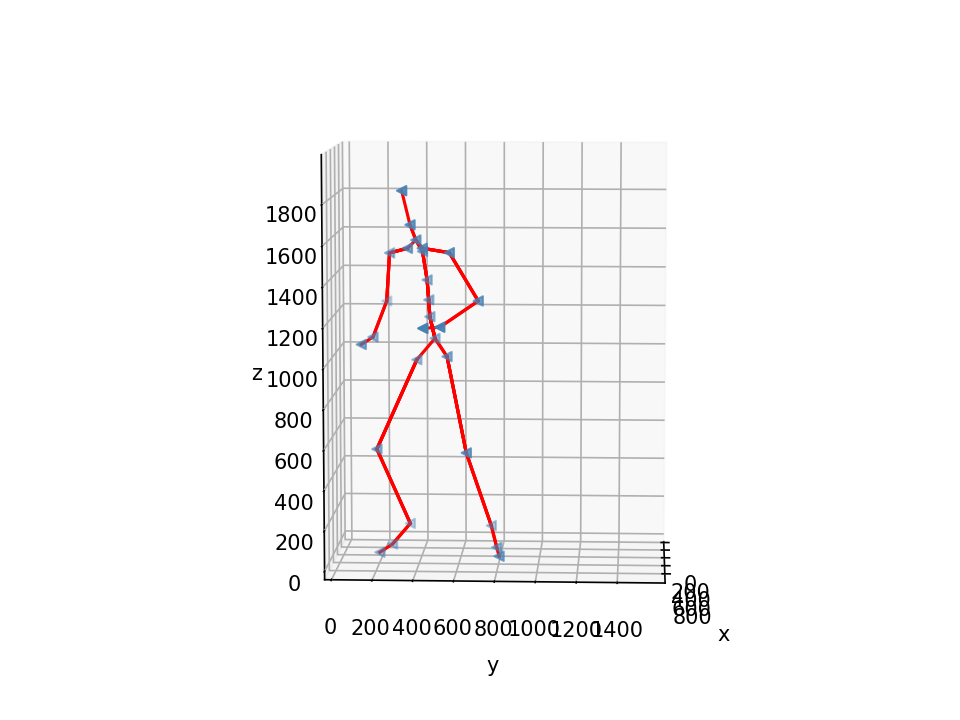

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import count
%matplotlib inline
# to rotate 3D plot interactively
%matplotlib notebook

frames = count()

def connect(points,frame,ax):
    idx_lst = [[],[],[]]
    for i in points:
        idx_lst[0].append(frame[0][i])
        idx_lst[1].append(frame[1][i])
        idx_lst[2].append(frame[2][i])
        ax.plot(idx_lst[0], idx_lst[1], idx_lst[2], color='red')

def connect_with_lines(frame,ax):
    connect([4,3,2,1,0,5,6,7],frame,ax) # spine and head
    connect([8,9,10,11,12],frame,ax) # left arm
    connect([13,14,15,16,17],frame,ax) # right arm
    connect([18,19,20,21,22],frame,ax) # left leg
    connect([23,24,25,26,27],frame,ax) # right leg
    connect([8,5,13],frame,ax) # shoulders and neck
    connect([18,4,23],frame,ax) # legs and hip

def get_coordinates(path):
    csv_df = pd.read_csv(path,header=None)
    csv_np = csv_df.to_numpy()
    labels = csv_np[0,:-1] # csv_np[:,0] is time(s), csv_np[:,-1] is Nah, throw csv_np[:,-1] away
    coords = csv_np[1:,:-1]
    coords = coords.astype(np.float32) # default in mm?
    # x,y,z
    x_coord = coords[:,1::3]
    y_coord = coords[:,2::3]
    z_coord = coords[:,3::3]
    print(x_coord.shape)
    print(y_coord.shape)
    print(z_coord.shape)
    return (x_coord,y_coord,z_coord)

def prepare_ax1(coords,ax1):
    # axis label
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    # axis limit
    x_high, x_low = int(np.ceil(coords[0].max()/200.0))*200, int(np.floor(coords[0].min()/200.0))*200
    y_high, y_low = int(np.ceil(coords[2].max()/200.0))*200, int(np.floor(coords[2].min()/200.0))*200
    z_high, z_low = int(np.ceil(coords[1].max()/200.0))*200, int(np.floor(coords[1].min()/200.0))*200
    print(x_high, x_low)
    print(y_high, y_low)
    print(z_high, z_low)
    ax1.axes.set_xlim3d(left=x_low, right=x_high) 
    ax1.axes.set_ylim3d(bottom=y_low, top=y_high) 
    ax1.axes.set_zlim3d(bottom=z_low, top=z_high) 
    # axis scale
    ax1.set_xticks(list(i for i in range(x_low,x_high,200)))
    ax1.set_yticks(list(i for i in range(y_low,y_high,200)))
    ax1.set_zticks(list(i for i in range(z_low,z_high,200)))
    # axis aspect ratio
    ax1.set_box_aspect(aspect = (x_high-x_low,y_high-y_low,z_high-z_low))

def plot_func(frame_id):
    plt.cla()
    current_frame = [coords[0][frame_id], coords[2][frame_id], coords[1][frame_id]] # x_pos,z_pos,y_pos
    prepare_ax1(coords,ax1)
    ax1.scatter3D(current_frame[0], current_frame[1], current_frame[2], c='steelblue', marker='<')
    connect_with_lines(current_frame,ax1)

# plot
path = 'NoHead_CSV/unknown.chart.NoHead.csv'
coords = get_coordinates(path)
N_frames = 600
fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.view_init(30, 30)
ani = animation.FuncAnimation(fig,plot_func,frames=N_frames,interval=17)
plt.show()

## Data from Unknown.csv

### Preprocess

<font size = 4>
   
All lines in **Unknown.csv** are saved in 1 column. Before being deploied, they need to be:
    
    1) converted into string
    2) split by delimiter
    3) converted into numpy.array
    
However, in original Unknown.csv, the first lines contains information of:
    
    1st line: recording information (e.g. recorded time)
    2nd line: number of frames
    3rd line: names of links (position and angle)
    4th line: axis (X,Y,Z)
    5th line: unit (mm, degree)
    
which have different columns after being split and converted into numpy.array, compared with the rest of lines, i.e. recorded values. This situation causes it difficult to index and slice with both **numpy** and **pandas**. As a result, before loading **Unknown.csv**, firstly delete the first lines inside except recorded values and save as Unknown.NoHead.csv.

</font>

### Extract data

<font size=4>
    
The direct reference of data is 3rd line in original .csv, but the number of colunms still differs. After detailed testing, the following results are obtained, which only contain information of position without angles. Note that the information below is from original .csv:
    
    frame;sub-frame;annotation;
    CenterOfGravity;;;
    LWristPositions;;;LWristAngles;;;LElbowPositions;;;LElbowAngles;;;LShoulderPositions;;;LShoulderAngles;;;
    RWristPositions;;;RWristAngles;;;RElbowPositions;;;RElbowAngles;;;RShoulderPositions;;;RShoulderAngles;;;
    LToePositions;;;LToeAngles;;;LAnklePositions;;;LAnkleAngles;;;LKneePositions;;;LKneeAngles;;;LHipPositions;;;LHipAngles;;;
    RToePositions;;;RToeAngles;;;RAnklePositions;;;RAnkleAngles;;;RKneePositions;;;RKneeAngles;;;RHipPositions;;;RHipAngles;;;
    LClaviclePositions;;;LClavicleAngles;;;LHandEndPositions;;;LHandEndAngles;;;LToesEndPositions;;;LToesEndAngles;;;
    RClaviclePositions;;;RClavicleAngles;;;RHandEndPositions;;;RHandEndAngles;;;RToesEndPositions;;;RToesEndAngles;;;
    Spine1Positions;;;Spine1Angles;;;Spine2Positions;;;Spine2Angles;;;Spine3Positions;;;Spine3Angles;;;Spine4Positions;;;Spine4Angles;;;Spine5Positions;;;Spine5Angles;;;
    NeckPosition;;;NeckAngles;;;HeadPositions;;;HeadAngles;;;HeadEndPositions;;;HeadEndRotations;;

And the index for extracting these data is recorded in next sector inside the codes, which is in function **get_prepared()**.
    
</font>

### Deploy data

<font size=4>
    
After extracting data from original .csv, new index for **x_pos**, **y_pos**, **z_pos** is:
    
    0:LWrist 1:LElbow 2:LShoulder
    3:RWrist 4:RElbow 5:RShoulder
    6:LToe 7:LAnkle 8:LKnee 9:LHip
    10:RToe 11:RAnkle 12:RKnee 13:RHip
    14:LClavicle 15:LHandEnd 16:LToesEnd
    17:RClavicle 18:RHandEnd 19:RToesEnd
    20:spine1 21:spine2 22:spine3 23:spine4 24:spine5 25:head 
    
Therefore, the links connected with these joints are defined **in order**:
    
    index 15,0,1,2,14: left arm
    index 18,3,4,5,17: right arm
    index 16,6,7,8,9: left leg
    index 19,10,11,12,13: right leg
    index 20,21,22,23,24: spine
    index 25: head

In [14]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime as dt
from itertools import count
%matplotlib inline
# to rotate 3D plot interactively
%matplotlib notebook

frames = count()

#################################
###### calculate distances ######
#################################
        
def calc_dist(coords,joints):
    dist_sum = np.zeros(coords[0].shape[0])
    for i,j in zip(joints[:-1],joints[1:]):
        dist_sum += np.sqrt((coords[0][:,i] - coords[0][:,j])**2 + (coords[1][:,i] - coords[1][:,j])**2 + (coords[2][:,i] - coords[2][:,j])**2)
    return dist_sum
    
def calc_distances_timeline(coords,joints_dict):
    dist_time = []
    for links,joints in joints_dict.items():
        dist_time.append(calc_dist(coords,joints))
    return dist_time

##############################
###### plot links in 3D ######
##############################

def connect(frame,ax,joints):
    idx_lst = [[],[],[]]
    for i in joints:
        idx_lst[0].append(frame[0][i])
        idx_lst[1].append(frame[1][i])
        idx_lst[2].append(frame[2][i])
        ax.plot(idx_lst[0], idx_lst[1], idx_lst[2], color='red')

def connect_with_lines(frame,ax,joints_dict):
    for links,joints in joints_dict.items():
        connect(frame,ax,joints)
        
#######################################
###### plot distance-lines in 2D ######
#######################################

def plot_distances(dist_time,frame_id,ax):
    for joints in dist_time:
        ax.plot(np.arange(frame_id),dist_time[joints][:frame_id+1])

#########################################################
###### get coordinates, distances, and joints list ######
#########################################################

def get_ori_data(path,save):
    
    csv_df = pd.read_csv(path ,header=None, delimiter=';')
    csv_np = csv_df.to_numpy()/1000.0 # mm -> m
    cog = csv_np[:,3:6]
    output_path = './Dataset_Proposal'

    # index in coords: x_pos, y_pos, z_pos:
    x_pos_ori = csv_np[:,[6,12,18,24,30,36,42,48,54,60,66,72,78,84,90,96,102,108,114,120,126,132,138,144,150,168]]
    y_pos_ori = csv_np[:,[7,13,19,25,31,37,43,49,55,61,67,73,79,85,91,97,103,109,115,121,127,133,139,145,151,169]]
    z_pos_ori = csv_np[:,[8,14,20,26,32,38,44,50,56,62,68,74,80,86,92,98,104,110,116,122,128,134,140,146,152,170]]
    print(f'x_pos shape: {x_pos_ori.shape}')
    
    if save == 'yes':
        num_row = x_pos_ori.shape[0]
        num_col = x_pos_ori.shape[1] * 3 + 3
        output_df = np.zeros((num_row,num_col))
        for frame,(C,X,Y,Z) in enumerate(zip(cog,x_pos_ori,y_pos_ori,z_pos_ori)):
            output_df[frame,0:3] = C # center of gravity
            output_df[frame,3::3] = X # x position
            output_df[frame,4::3] = Y # y position
            output_df[frame,5::3] = Z # z position
        df = pd.DataFrame(output_df)
        df.to_csv(os.path.join(output_path,'coordinates.csv'),index=False,header=False)
    
    return cog,x_pos_ori,y_pos_ori,z_pos_ori
    
def get_prepared(path):

    cog,x_pos_ori,y_pos_ori,z_pos_ori = get_ori_data(path=path,save='no')
    coords_ori = [x_pos_ori,y_pos_ori,z_pos_ori]
    
    x_pos_withoutCOG = x_pos_ori-np.expand_dims(cog[:,0],axis=1)
    y_pos_withoutCOG = y_pos_ori-np.expand_dims(cog[:,1],axis=1)
    z_pos_withoutCOG = z_pos_ori-np.expand_dims(cog[:,2],axis=1)
    coords_withoutCOG = [x_pos_withoutCOG,y_pos_withoutCOG,z_pos_withoutCOG]
    
    x_pos_withoutCOG_bias = x_pos_withoutCOG - np.amin(x_pos_withoutCOG)
    y_pos_withoutCOG_bias = y_pos_withoutCOG - np.amin(y_pos_withoutCOG)
    z_pos_withoutCOG_bias = z_pos_withoutCOG - np.amin(z_pos_withoutCOG)
    coords_withoutCOG_bias = [x_pos_withoutCOG_bias,y_pos_withoutCOG_bias,z_pos_withoutCOG_bias]
    
    # joints list
    joints_dict = {'left arm': [15,0,1,2,14,24],
                  'right arm': [18,3,4,5,17,24],
                  'left leg': [16,6,7,8,9,20],
                  'right leg': [19,10,11,12,13,20],
                  'spine': [20,21,22,23,24,25]
                 }
    
    # change of distances
    dist_time = calc_distances_timeline(coords_ori,joints_dict)
    
    return coords_ori,coords_withoutCOG,coords_withoutCOG_bias,dist_time,joints_dict

##################################
###### plot with each frame ######
##################################

def prepare_ax(coords,ax):
    # axis label
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    # axis limit
    x_high, x_low = int(np.ceil(coords[0].max()*1000/200.0))*200, int(np.floor(coords[0].min()*1000/200.0))*200
    y_high, y_low = int(np.ceil(coords[2].max()*1000/200.0))*200, int(np.floor(coords[2].min()*1000/200.0))*200
    z_high, z_low = int(np.ceil(coords[1].max()*1000/200.0))*200, int(np.floor(coords[1].min()*1000/200.0))*200
    ax.axes.set_xlim3d(left=x_low/1000.0, right=x_high/1000.0) 
    ax.axes.set_ylim3d(bottom=y_low/1000.0, top=y_high/1000.0)
    ax.axes.set_zlim3d(bottom=z_low/1000.0, top=z_high/1000.0)
    # axis scale
    ax.set_xticks(list(i/1000.0 for i in range(x_low,x_high,200)))
    ax.set_yticks(list(i/1000.0 for i in range(y_low,y_high,200)))
    ax.set_zticks(list(i/1000.0 for i in range(z_low,z_high,200)))
    # axis aspect ratio
    ax.set_box_aspect(aspect = (x_high-x_low,y_high-y_low,z_high-z_low))

def plot_func(frame_id):
    # plot links in 3D 
    ax1.cla()
    current_frame_1 = [coords_ori[0][frame_id], coords_ori[2][frame_id], coords_ori[1][frame_id]] # x_pos,z_pos,y_pos
    prepare_ax(coords_ori,ax1)
    ax1.set_title(f'Ori coords')
    ax1.scatter3D(current_frame_1[0], current_frame_1[1], current_frame_1[2], c='steelblue', marker='<')
    connect_with_lines(current_frame_1,ax1,joints_dict)

    # plot distance-lines in 2D
    # attentions:
    #    don't call ax.cla() for 2D projection, because previous plot is needed
    ax2.set_title(f'Link distances')
    x = np.arange(frame_id)
    for idx,dist_plot in enumerate(dist_plots):
        dist_plot.set_data(x, dist_time[idx][:frame_id])

    # plot links in 3D 
    ax3.cla()
    current_frame_3 = [coords_withoutCOG[0][frame_id], coords_withoutCOG[2][frame_id], coords_withoutCOG[1][frame_id]] # x_pos,z_pos,y_pos
    prepare_ax(coords_withoutCOG,ax3)
    ax3.set_title(f'Coords - CoG')
    ax3.scatter3D(current_frame_3[0], current_frame_3[1], current_frame_3[2], c='steelblue', marker='<')
    connect_with_lines(current_frame_3,ax3,joints_dict)

    # plot links in 3D 
    ax4.cla()
    current_frame_4 = [coords_withoutCOG_bias[0][frame_id], coords_withoutCOG_bias[2][frame_id], coords_withoutCOG_bias[1][frame_id]] # x_pos,z_pos,y_pos
    prepare_ax(coords_withoutCOG_bias,ax4)
    ax4.scatter3D(current_frame_4[0], current_frame_4[1], current_frame_4[2], c='steelblue', marker='<')
    ax4.set_title(f'Coords - CoG - Min')
    connect_with_lines(current_frame_4,ax4,joints_dict)

In [15]:
# save coordinates into .csv
cog,x_pos_ori,y_pos_ori,z_pos_ori = get_ori_data(path=path,save='yes')

x_pos shape: (600, 26)


x_pos shape: (600, 26)


<IPython.core.display.Javascript object>


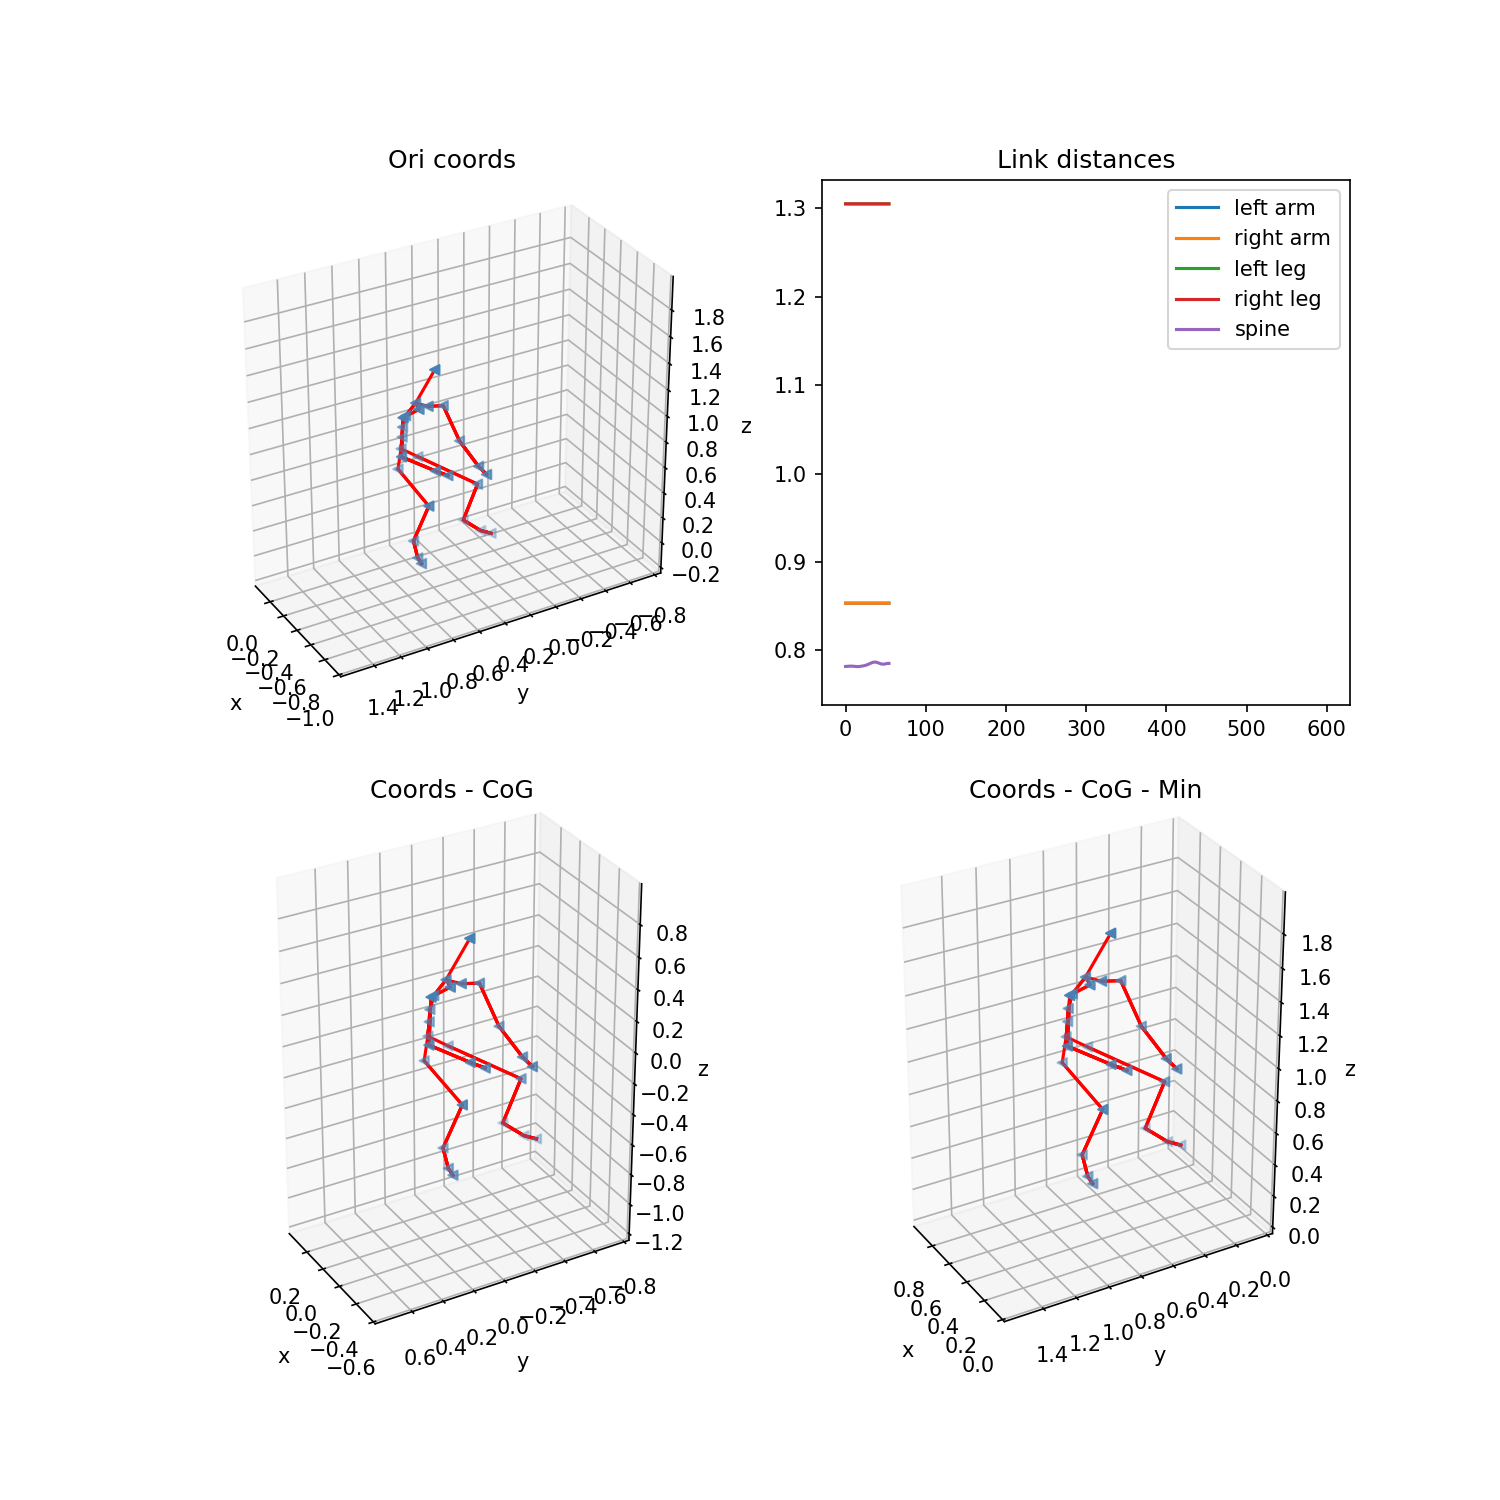

In [6]:
path = 'NoHead_CSV/unknown.NoHead.csv'
coords_ori,coords_withoutCOG,coords_withoutCOG_bias,dist_time,joints_dict = get_prepared(path)
N_frames = 600
fig = plt.figure(figsize=(10,10))
fig.tight_layout()

# plot links in 3D 
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.view_init(30, 150)

# plot distance-lines in 2D
ax2 = fig.add_subplot(2, 2, 2)
x = np.arange(N_frames)
dist_plots = [ax2.plot(x, dist_time[idx][:N_frames],label=f'{links}')[0] for idx,(links,joints) in enumerate(joints_dict.items())]
plt.legend()
# dist_plots = [ax2.plot(x, dist_time[2][:N_frames])[0]]

# plot links in 3D 
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.view_init(30, 150)

# plot links in 3D 
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.view_init(30, 150)

# animation
ani = animation.FuncAnimation(fig,plot_func,frames=N_frames,interval=17)
plt.show()

# save .gif
# writergif = animation.PillowWriter(fps=30) 
# ani.save(f"{dt.now().strftime('%d-%h-%H-%M')}_anim.gif", writer=writergif)

## Data from Unknown.csv

### Preprocess

<font size = 4>
   
In original Unknown.chart.distances.csv, the first line is title, the second line is name of joints, which have different columns, making it difficult to preprocess with the rest of data. Delete first line and save as Unknown.chart.distances.NoHead.csv.

</font>

### absolute distances

<font size=4>
    
Unknown.chart.distances.NoHead.csv contains the absolute distances between specific 2 joints, which is presented in the name of corresponding place. e.g. **RightHand_rx - Head_ry Distance [mm]** means the absolute distance in unit **[mm]** between **RigthHand** joint and **Head** joint. The name and index of each column is shown below:
    
    0: Seconds,
    1: RightHand_rx - Head_ry Distance [mm],
    2: RightHand_rx - HeadEE Distance [mm],
    3: RightForeArm_rx - Head_ry Distance [mm],
    4: RightForeArm_rx - HeadEE Distance [mm],
    5: RightHand_rx - RightArm_tx Distance [mm],
    6: RightHand_rx - floor Distance [mm],
    7: RightLeg_rx - floor Distance [mm],
    8: RightUpLeg_tx - floor Distance [mm],
    9: LeftHand_rx - Head_ry Distance [mm],
    10: LeftHand_rx - HeadEE Distance [mm],
    11: LeftForeArm_rx - Head_ry Distance [mm],
    12: LeftForeArm_rx - HeadEE Distance [mm],
    13: LeftHand_rx - LeftArm_tx Distance [mm],
    14: LeftHand_rx - floor Distance [mm],
    15: LeftLeg_rx - floor Distance [mm],
    16: LeftUpLeg_tx - floor Distance [mm],
    17: LeftHand_rx - RightHand_rx Distance [mm],
    
</font>

### Rename in array

<font size=4>
    
After extracting data from original .csv and neglect column **seconds**, new name and index for each column is:
    
    0: RightHand_Head,
    1: RightHand_HeadEE,
    2: RightForeArm_Head,
    3: RightForeArm_HeadEE,
    4: RightHand_RightArm,
    5: RightHand_floor,
    6: RightLeg_floor,
    7: RightUpLeg_floor,
    8: LeftHand_Head,
    9: LeftHand_HeadEE,
    10: LeftForeArm_Head,
    11: LeftForeArm_HeadEE,
    12: LeftHand_LeftArm,
    13: LeftHand_floor,
    14: LeftLeg_floor,
    15: LeftUpLeg_floor,
    16: LeftHand_RightHand,

data shape: (624, 17)


<IPython.core.display.Javascript object>


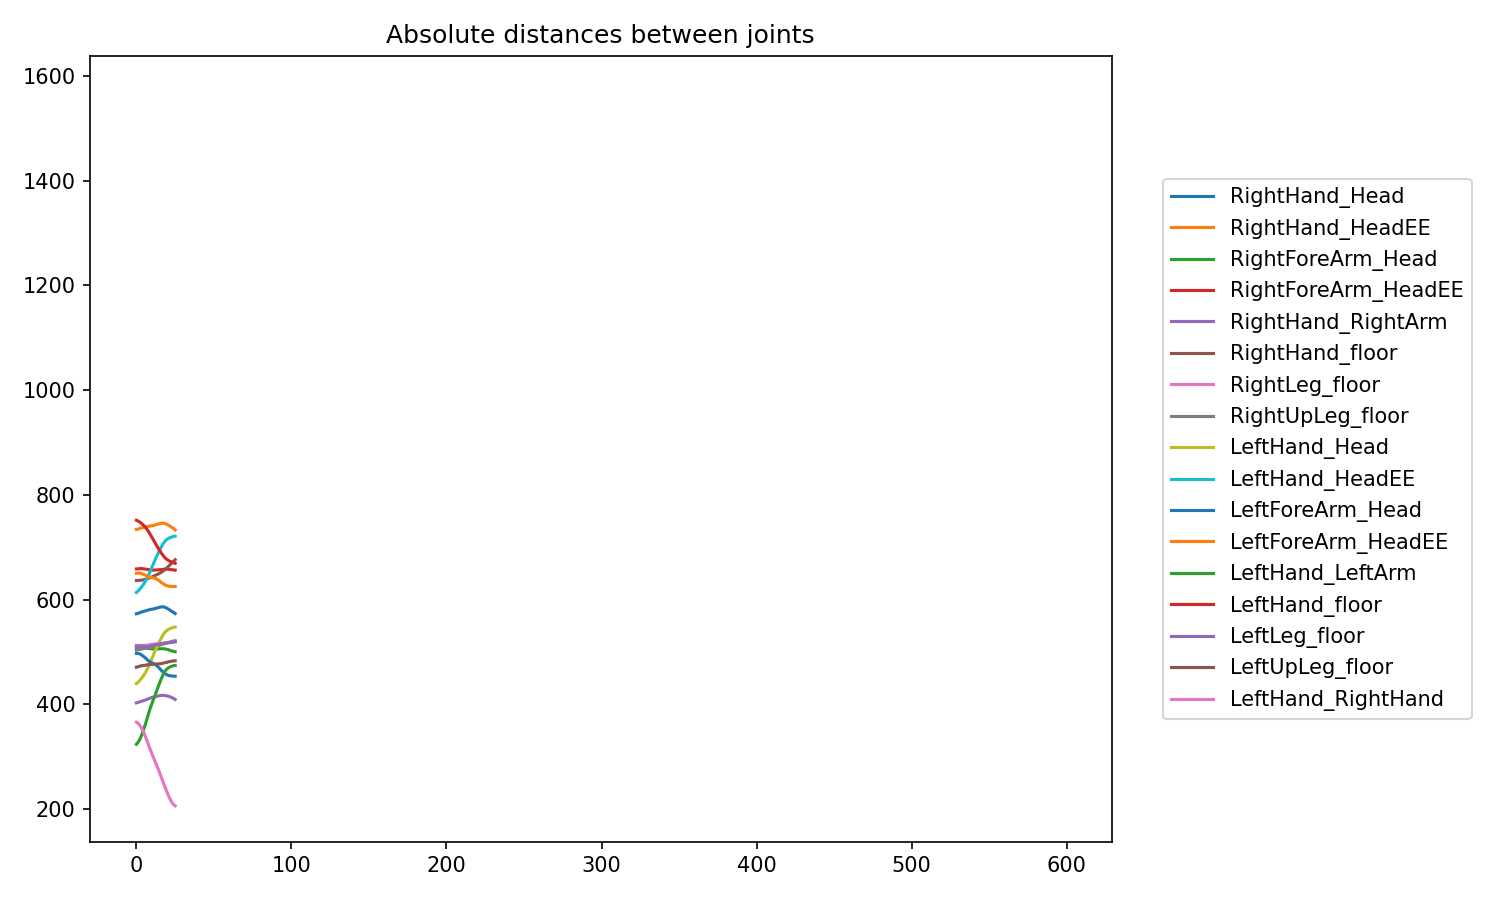

In [5]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import count
%matplotlib inline
# to rotate 3D plot interactively
%matplotlib notebook

frames = count()

def get_data(path):
    csv_df = pd.read_csv(path,header=None)
    csv_np = csv_df.to_numpy()
    names = csv_np[0,:-1] # csv_np[:,0] is time(s), csv_np[:,-1] is Nah, throw csv_np[:,-1] away
    data = csv_np[1:,1:-1] # discord "seconds"
    data = data.astype(np.float32) # default in mm
    print(f'data shape: {data.shape}')
    name_lst = ['RightHand_Head',
                'RightHand_HeadEE',
                'RightForeArm_Head',
                'RightForeArm_HeadEE',
                'RightHand_RightArm',
                'RightHand_floor',
                'RightLeg_floor',
                'RightUpLeg_floor',
                'LeftHand_Head',
                'LeftHand_HeadEE',
                'LeftForeArm_Head',
                'LeftForeArm_HeadEE',
                'LeftHand_LeftArm',
                'LeftHand_floor',
                'LeftLeg_floor',
                'LeftUpLeg_floor',
                'LeftHand_RightHand'
               ]
    
    return data,name_lst

def prepare_ax1(coords,ax1):
    # axis label
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    # axis limit
    x_high, x_low = int(np.ceil(coords[0].max()/200.0))*200, int(np.floor(coords[0].min()/200.0))*200
    y_high, y_low = int(np.ceil(coords[2].max()/200.0))*200, int(np.floor(coords[2].min()/200.0))*200
    z_high, z_low = int(np.ceil(coords[1].max()/200.0))*200, int(np.floor(coords[1].min()/200.0))*200
    print(x_high, x_low)
    print(y_high, y_low)
    print(z_high, z_low)
    ax1.axes.set_xlim3d(left=x_low, right=x_high) 
    ax1.axes.set_ylim3d(bottom=y_low, top=y_high) 
    ax1.axes.set_zlim3d(bottom=z_low, top=z_high) 
    # axis scale
    ax1.set_xticks(list(i for i in range(x_low,x_high,200)))
    ax1.set_yticks(list(i for i in range(y_low,y_high,200)))
    ax1.set_zticks(list(i for i in range(z_low,z_high,200)))
    # axis aspect ratio
    ax1.set_box_aspect(aspect = (x_high-x_low,y_high-y_low,z_high-z_low))

def plot_func(frame_id):
    # attentions:
    #    don't call ax.cla() for 2D projection, because previous plot is needed
    x = np.arange(frame_id)
    for idx,joints_dist_plot in enumerate(joints_dist_plots):
        joints_dist_plot.set_data(x, data[idx][:frame_id])

# plot
path = 'NoHead_CSV/unknown.chart.distances.NoHead.csv'
N_frames = 600
data,name_lst = get_data(path)
data = np.transpose(data) # data: [frames,dist_names] -> [dist_names,frames]
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,1,1)
x = np.arange(N_frames)
joints_dist_plots = [ax1.plot(x, data[idx][:N_frames],label=f'{name}')[0] for idx,name in enumerate(name_lst)]
ax1.set_title(f'Absolute distances between joints')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.tight_layout()
ani = animation.FuncAnimation(fig,plot_func,frames=N_frames,interval=17)
plt.show()


## Reference
<font size = 4>
matplotlib.animation.FuncAnimation:

https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation

Example of FuncAnimation:

https://matplotlib.org/stable/gallery/animation/random_walk.html